In [21]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

DATA_PATH = Path().cwd().parent / "data"


def read_data(file_name):
    return pd.read_csv(DATA_PATH / file_name, parse_dates=True)


shipments_df = read_data("shipments.csv")
po_df = read_data("purchase_orders.csv")
suppliers_df = read_data("suppliers.csv")
skus_df = read_data("skus.csv")
transit_events_df = read_data("transit_events.csv")
sites_df = read_data("sites.csv")
deployments_df = read_data("deployments.csv")
rma_df = read_data("rma_returns.csv")
inventory_df = read_data("inventory_snapshots.csv")
_datetime_map = {
    "shipments": (shipments_df, ["ship_date", "eta_date", "actual_delivery_date"]),
    "purchase_orders": (po_df, ["order_date", "promised_date"]),
    "transit_events": (transit_events_df, ["event_ts"]),
}
for _, (df, cols) in _datetime_map.items():
    for col in cols:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], errors="coerce")

rma_df

,rma_id,sku_id,site_id,reason_code,rma_date,under_warranty
0,RMA-0000001,SKU-00206,ST-01094,DOA,2024-10-15,True
1,RMA-0000002,SKU-02303,ST-01174,RF_FAULT,2023-11-05,False
2,RMA-0000003,SKU-04015,ST-01643,RF_FAULT,2025-03-26,True
3,RMA-0000004,SKU-00438,ST-01539,DOA,2025-02-25,True
4,RMA-0000005,SKU-02819,ST-00776,MECH_DAMAGE,2023-06-02,True
...,...,...,...,...,...,...
39995,RMA-0039996,SKU-03476,ST-00497,FIRMWARE,2025-04-21,False
39996,RMA-0039997,SKU-03575,ST-00730,RF_FAULT,2025-06-05,False
39997,RMA-0039998,SKU-03710,ST-01314,DOA,2025-09-01,True
39998,RMA-0039999,SKU-01080,ST-00275,INTERMITTENT,2025-04-06,True


Detect sites with abnormal failure rates (RMA spike detection).

In [22]:
# STEP 1: Prepare time series data
rma_df['rma_date'] = pd.to_datetime(rma_df['rma_date'])

# Create weekly time series by site
weekly_ts = (
    rma_df
    .groupby(['site_id', pd.Grouper(key='rma_date', freq='W-MON')])
    .size()
    .reset_index(name='rma_count')
    .sort_values(['site_id', 'rma_date'])
)

# Filter: Only keep sites with meaningful activity (at least 3 total RMAs in dataset)
site_totals = weekly_ts.groupby('site_id')['rma_count'].sum()
active_sites = site_totals[site_totals >= 3].index
weekly_ts = weekly_ts[weekly_ts['site_id'].isin(active_sites)]

print(f"Total sites with RMA activity: {len(site_totals)}")
print(f"Sites with ≥3 RMAs (analysis subset): {len(active_sites)}")
weekly_ts

Total sites with RMA activity: 2000
Sites with ≥3 RMAs (analysis subset): 2000


,site_id,rma_date,rma_count
0,ST-00001,2023-01-09,1
1,ST-00001,2023-02-20,1
2,ST-00001,2023-04-03,1
3,ST-00001,2023-04-24,1
4,ST-00001,2023-05-01,1
...,...,...,...
37365,ST-02000,2023-11-20,1
37366,ST-02000,2024-06-10,1
37367,ST-02000,2024-06-24,1
37368,ST-02000,2024-07-01,1


In [23]:
# STEP 2: Calculate Rolling Statistics (Historical Baseline)
# Use 4-week lookback window, shifted by 1 week to avoid using current week in baseline

weekly_ts['rolling_mean'] = (
    weekly_ts.groupby('site_id')['rma_count']
    .shift(1)  # Don't include current week
    .rolling(window=4, min_periods=2)  # Need at least 2 weeks of history
    .mean()
    .reset_index(0, drop=True)
)

weekly_ts['rolling_std'] = (
    weekly_ts.groupby('site_id')['rma_count']
    .shift(1)
    .rolling(window=4, min_periods=2)
    .std()
    .reset_index(0, drop=True)
)

# Handle edge cases
weekly_ts['rolling_std'] = weekly_ts['rolling_std'].fillna(0.5).replace(0, 0.5)  # Minimum std
weekly_ts['rolling_mean'] = weekly_ts['rolling_mean'].fillna(0)

# Add useful context metrics
weekly_ts['deviation'] = weekly_ts['rma_count'] - weekly_ts['rolling_mean']
weekly_ts['pct_change'] = ((weekly_ts['rma_count'] - weekly_ts['rolling_mean']) / 
                            (weekly_ts['rolling_mean'] + 0.01)) * 100  # Avoid div by zero

weekly_ts[['site_id', 'rma_date', 'rma_count', 'rolling_mean', 'rolling_std', 'deviation', 'pct_change']]

,site_id,rma_date,rma_count,rolling_mean,rolling_std,deviation,pct_change
0,ST-00001,2023-01-09,1,0.0,0.5,1.0,10000.0
1,ST-00001,2023-02-20,1,0.0,0.5,1.0,10000.0
2,ST-00001,2023-04-03,1,1.0,0.5,0.0,0.0
3,ST-00001,2023-04-24,1,1.0,0.5,0.0,0.0
4,ST-00001,2023-05-01,1,1.0,0.5,0.0,0.0
...,...,...,...,...,...,...,...
37365,ST-02000,2023-11-20,1,1.0,0.5,0.0,0.0
37366,ST-02000,2024-06-10,1,1.0,0.5,0.0,0.0
37367,ST-02000,2024-06-24,1,1.0,0.5,0.0,0.0
37368,ST-02000,2024-07-01,1,1.0,0.5,0.0,0.0


In [24]:
# STEP 3: Calculate Z-Scores and Severity Levels
weekly_ts['z_score'] = (weekly_ts['rma_count'] - weekly_ts['rolling_mean']) / weekly_ts['rolling_std']

# Define severity levels for actionable insights
def get_severity(row):
    z = row['z_score']
    count = row['rma_count']
    
    # Must have at least 2 RMAs to be considered
    if count < 2:
        return 'Normal'
    
    if z >= 3.0:
        return 'Critical'
    elif z >= 2.0:
        return 'High'
    elif z >= 1.5:
        return 'Medium'
    else:
        return 'Normal'

weekly_ts['severity'] = weekly_ts.apply(get_severity, axis=1)

print("Severity Distribution:")
print(weekly_ts['severity'].value_counts())
print(f"\nTotal weeks analyzed: {len(weekly_ts)}")
print(f"Anomalous weeks (Medium+): {len(weekly_ts[weekly_ts['severity'] != 'Normal'])}")

Severity Distribution:
severity
Normal      35432
High         1826
Critical      109
Medium          3
Name: count, dtype: int64

Total weeks analyzed: 37370
Anomalous weeks (Medium+): 1938


In [25]:
# Identify and Enrich Anomalies
anomalies = weekly_ts[weekly_ts['severity'].isin(['Medium', 'High', 'Critical'])].copy()

# Merge with site metadata
anomalies = anomalies.merge(
    sites_df[['site_id', 'region', 'site_type', 'country', 'operator']], 
    on='site_id', 
    how='left'
)

# Calculate additional context for each anomaly
anomalies['week_number'] = anomalies['rma_date'].dt.isocalendar().week
anomalies['year'] = anomalies['rma_date'].dt.year

# Round numeric columns for readability
anomalies['rolling_mean'] = anomalies['rolling_mean'].round(2)
anomalies['rolling_std'] = anomalies['rolling_std'].round(2)
anomalies['z_score'] = anomalies['z_score'].round(2)
anomalies['deviation'] = anomalies['deviation'].round(2)
anomalies['pct_change'] = anomalies['pct_change'].round(1)

anomalies = anomalies.sort_values(['severity', 'z_score'], ascending=[True, False])

print(f"\n✓ Detected {len(anomalies)} anomalous weeks across {anomalies['site_id'].nunique()} sites")
print(f"\nBy Severity:")
print(anomalies['severity'].value_counts())
anomalies


✓ Detected 1938 anomalous weeks across 1416 sites

By Severity:
severity
High        1826
Critical     109
Medium         3
Name: count, dtype: int64


,site_id,rma_date,rma_count,rolling_mean,rolling_std,deviation,pct_change,z_score,severity,region,site_type,country,operator,week_number,year
239,ST-00240,2024-06-03,4,1.00,0.5,3.00,297.0,6.0,Critical,EMEA,Warehouse,Germany,NaN,23,2024
914,ST-00935,2024-01-22,4,1.00,0.5,3.00,297.0,6.0,Critical,EMEA,Warehouse,France,NaN,4,2024
1382,ST-01429,2024-09-23,4,1.00,0.5,3.00,297.0,6.0,Critical,EMEA,Warehouse,Czechia,NaN,39,2024
1539,ST-01564,2023-07-17,4,1.00,0.5,3.00,297.0,6.0,Critical,EMEA,Warehouse,Netherlands,NaN,29,2023
1352,ST-01400,2025-06-16,4,1.25,0.5,2.75,218.3,5.5,Critical,AMER,Cell Site,Argentina,Verizon,25,2025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1936,ST-01999,2023-11-20,2,1.00,0.5,1.00,99.0,2.0,High,AMER,Warehouse,Chile,NaN,47,2023
1937,ST-02000,2023-03-13,2,1.00,0.5,1.00,99.0,2.0,High,EMEA,Cell Site,Spain,Vodafone,11,2023
4,ST-00002,2024-01-15,2,1.25,0.5,0.75,59.5,1.5,Medium,APAC,Cell Site,South Korea,Singtel,3,2024
5,ST-00002,2024-01-22,2,1.25,0.5,0.75,59.5,1.5,Medium,APAC,Cell Site,South Korea,Singtel,4,2024


In [26]:
# STEP 5: Detect Consecutive Spikes (Persistent Issues)
# Sites with multiple consecutive anomalous weeks indicate systemic problems

anomalies = anomalies.sort_values(['site_id', 'rma_date'])

# Flag consecutive anomalies
anomalies['days_since_last_anomaly'] = (
    anomalies.groupby('site_id')['rma_date']
    .diff()
    .dt.days
)

# Mark consecutive (within 14 days = ~2 weeks)
anomalies['is_consecutive'] = anomalies['days_since_last_anomaly'] <= 14

# Count consecutive streaks per site
consecutive_sites = (
    anomalies[anomalies['is_consecutive']]
    .groupby('site_id')
    .size()
    .reset_index(name='consecutive_count')
    .sort_values('consecutive_count', ascending=False)
)

print(f"\n⚠️  Sites with consecutive anomalies (persistent issues): {len(consecutive_sites)}")
print("\nTop sites with recurring problems:")
print(consecutive_sites.head(10))

# Add this info to anomalies table
anomalies = anomalies.merge(
    consecutive_sites[['site_id', 'consecutive_count']], 
    on='site_id', 
    how='left'
)
anomalies['consecutive_count'] = anomalies['consecutive_count'].fillna(0).astype(int)

anomalies[['site_id', 'rma_date', 'rma_count', 'z_score', 'severity', 'consecutive_count', 'region']]


⚠️  Sites with consecutive anomalies (persistent issues): 4

Top sites with recurring problems:
    site_id  consecutive_count
0  ST-00002                  1
1  ST-00009                  1
2  ST-00806                  1
3  ST-01817                  1


,site_id,rma_date,rma_count,z_score,severity,consecutive_count,region
0,ST-00001,2024-04-15,2,2.0,High,0,EMEA
1,ST-00001,2025-03-17,2,2.0,High,0,EMEA
2,ST-00001,2025-09-22,2,2.0,High,0,EMEA
3,ST-00002,2023-11-13,2,2.0,High,1,APAC
4,ST-00002,2024-01-15,2,1.5,Medium,1,APAC
...,...,...,...,...,...,...,...
1933,ST-01997,2024-01-29,2,2.0,High,0,EMEA
1934,ST-01997,2025-07-07,2,2.0,High,0,EMEA
1935,ST-01998,2023-12-11,2,2.0,High,0,APAC
1936,ST-01999,2023-11-20,2,2.0,High,0,AMER


In [27]:
# per site failures 

# add encoded failure reasons count to sites table
failures_count_by_site = (
    rma_df
    .groupby('site_id')['reason_code']
    .value_counts()
    .unstack(fill_value=0)
    .reset_index()
)
failures_count_by_site

sites_enriched = sites_df.merge(failures_count_by_site, on='site_id', how='left').fillna(0)
# if operator = 0 - null
sites_enriched['operator'] = sites_enriched['operator'].replace(0, np.nan)
sites_enriched


,site_id,region,country,site_type,operator,latitude,longitude,DOA,FIRMWARE,INTERMITTENT,MECH_DAMAGE,NO_POWER,OTHER,OVERHEAT,RF_FAULT
0,ST-00001,EMEA,Italy,Cell Site,Three,44.65748,-3.44596,3,3,3,2,1,6,3,7
1,ST-00002,APAC,South Korea,Cell Site,Singtel,19.46501,122.29595,5,5,3,2,3,2,3,0
2,ST-00003,EMEA,Austria,Warehouse,NaN,41.41491,27.75070,4,7,1,1,1,1,5,7
3,ST-00004,EMEA,Italy,Integration Center,NaN,51.17115,-1.20329,0,6,4,2,1,1,2,2
4,ST-00005,AMER,Canada,Cell Site,Verizon,-19.96994,-93.20117,2,3,0,4,1,4,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,ST-01996,EMEA,Germany,Cell Site,Deutsche Telekom,51.78151,16.61375,6,2,2,2,2,1,1,6
1996,ST-01997,EMEA,UK,Integration Center,NaN,42.72560,-2.44060,5,3,2,2,0,4,3,3
1997,ST-01998,APAC,Indonesia,Cell Site,Bharti Airtel,6.12165,95.68893,3,0,1,3,3,2,4,1
1998,ST-01999,AMER,Chile,Warehouse,NaN,38.59298,-88.55401,3,5,1,2,3,5,1,4


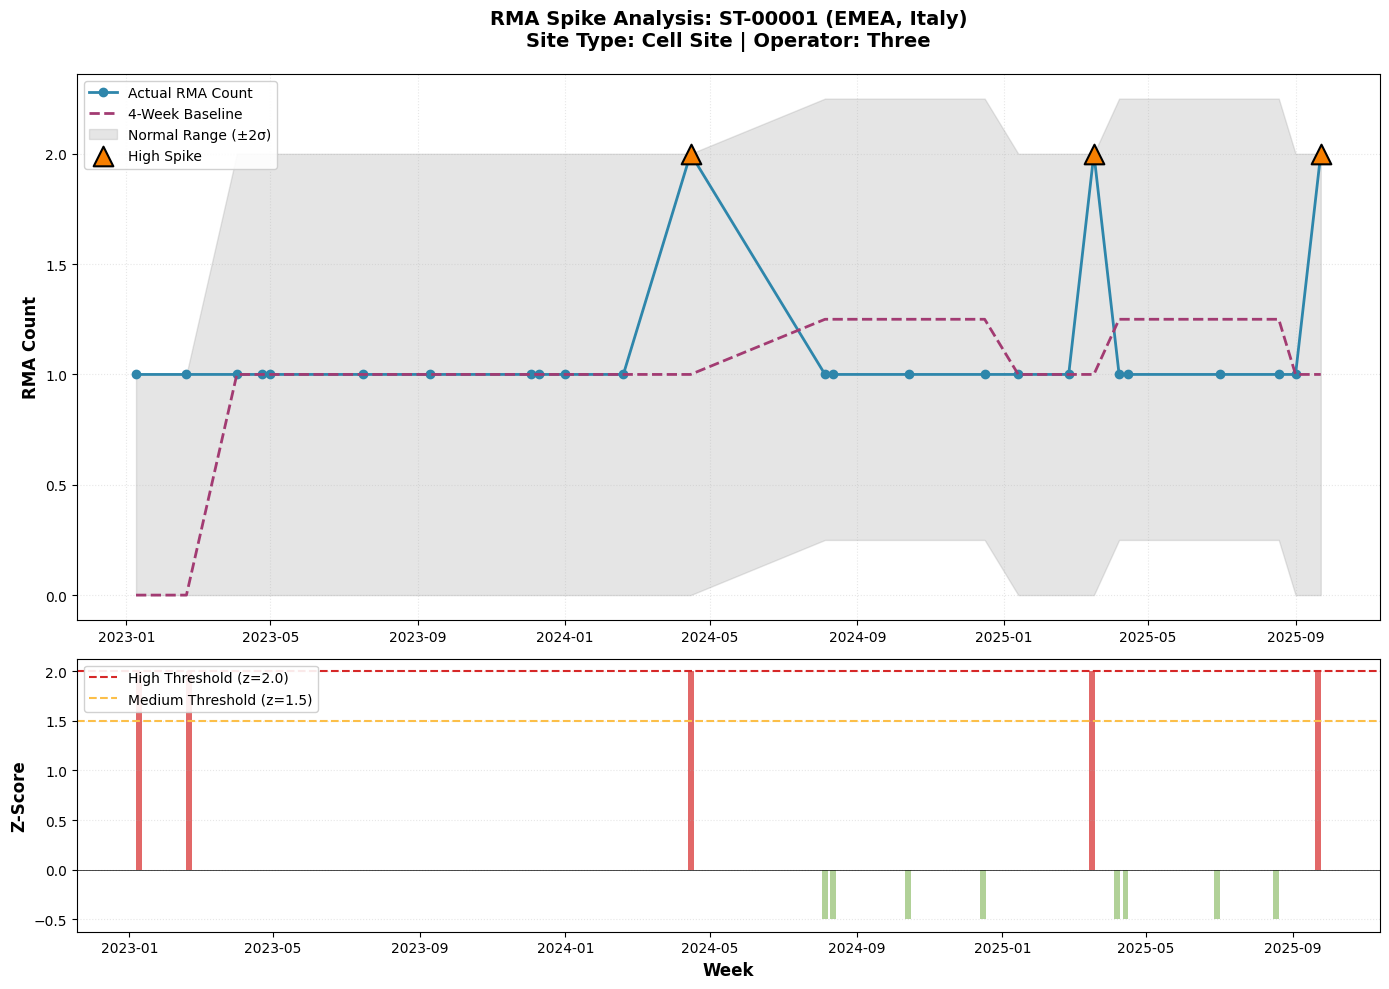


📊 Summary for ST-00001:
   Total anomalous weeks: 3
   Highest z-score: 2.00
   Date range: 2023-01-09 to 2025-09-22


In [28]:
# STEP 6: Visualize Top Anomaly with Enhanced Chart
top_anomaly = anomalies.iloc[0]
top_site = top_anomaly['site_id']
site_data = weekly_ts[weekly_ts['site_id'] == top_site].copy()

# Calculate upper/lower control limits (2 std dev)
site_data['upper_limit'] = site_data['rolling_mean'] + (2 * site_data['rolling_std'])
site_data['lower_limit'] = site_data['rolling_mean'] - (2 * site_data['rolling_std'])
site_data['lower_limit'] = site_data['lower_limit'].clip(lower=0)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), height_ratios=[2, 1])

# Main chart
ax1.plot(site_data['rma_date'], site_data['rma_count'], 
         marker='o', linewidth=2, label='Actual RMA Count', color='#2E86AB', markersize=6)
ax1.plot(site_data['rma_date'], site_data['rolling_mean'], 
         linestyle='--', color='#A23B72', label='4-Week Baseline', linewidth=2)

# Control limits
ax1.fill_between(site_data['rma_date'], 
                  site_data['lower_limit'], 
                  site_data['upper_limit'],
                  alpha=0.2, color='gray', label='Normal Range (±2σ)')

# Highlight anomalies by severity
site_anoms = anomalies[anomalies['site_id'] == top_site]
severity_colors = {'Critical': '#D62828', 'High': '#F77F00', 'Medium': '#FCBF49'}

for severity, color in severity_colors.items():
    sev_data = site_anoms[site_anoms['severity'] == severity]
    if not sev_data.empty:
        ax1.scatter(sev_data['rma_date'], sev_data['rma_count'], 
                   color=color, s=200, zorder=5, label=f'{severity} Spike', 
                   edgecolors='black', linewidths=1.5, marker='^')

ax1.set_title(f'RMA Spike Analysis: {top_site} ({top_anomaly["region"]}, {top_anomaly["country"]})\n' +
              f'Site Type: {top_anomaly["site_type"]} | Operator: {top_anomaly.get("operator", "N/A")}',
              fontsize=14, fontweight='bold', pad=20)
ax1.set_ylabel('RMA Count', fontsize=12, fontweight='bold')
ax1.legend(loc='upper left', framealpha=0.9)
ax1.grid(True, alpha=0.3, linestyle=':')

# Z-score chart
ax2.bar(site_data['rma_date'], site_data['z_score'], 
        color=['#D62828' if z >= 2 else '#FCBF49' if z >= 1.5 else '#90BE6D' 
               for z in site_data['z_score']], alpha=0.7, width=5)
ax2.axhline(y=2.0, color='#D62828', linestyle='--', linewidth=1.5, label='High Threshold (z=2.0)')
ax2.axhline(y=1.5, color='#FCBF49', linestyle='--', linewidth=1.5, label='Medium Threshold (z=1.5)')
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax2.set_ylabel('Z-Score', fontsize=12, fontweight='bold')
ax2.set_xlabel('Week', fontsize=12, fontweight='bold')
ax2.legend(loc='upper left', framealpha=0.9)
ax2.grid(True, alpha=0.3, axis='y', linestyle=':')

plt.tight_layout()
plt.show()

print(f"\n📊 Summary for {top_site}:")
print(f"   Total anomalous weeks: {len(site_anoms)}")
print(f"   Highest z-score: {site_anoms['z_score'].max():.2f}")
print(f"   Date range: {site_data['rma_date'].min().date()} to {site_data['rma_date'].max().date()}")


📍 Anomalies by Region and Severity:
severity  Critical  High  Medium  Total
region                                 
EMEA            52  1073       1   1126
APAC            36   420       2    458
AMER            21   333       0    354


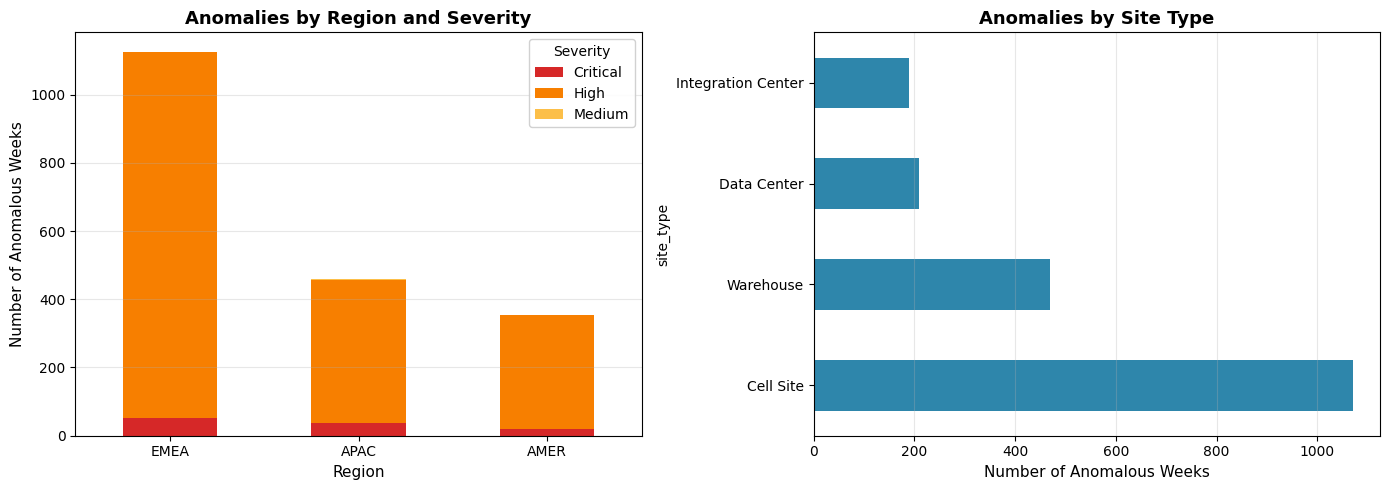

In [29]:
# STEP 7: Regional Analysis - Where are the problems?
regional_summary = (
    anomalies.groupby(['region', 'severity'])
    .size()
    .reset_index(name='count')
    .pivot(index='region', columns='severity', values='count')
    .fillna(0)
    .astype(int)
)

# Add total column
regional_summary['Total'] = regional_summary.sum(axis=1)
regional_summary = regional_summary.sort_values('Total', ascending=False)

print("\n📍 Anomalies by Region and Severity:")
print(regional_summary)

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Stacked bar chart
regional_summary[['Critical', 'High', 'Medium']].plot(
    kind='bar', stacked=True, ax=ax1,
    color=['#D62828', '#F77F00', '#FCBF49']
)
ax1.set_title('Anomalies by Region and Severity', fontsize=13, fontweight='bold')
ax1.set_xlabel('Region', fontsize=11)
ax1.set_ylabel('Number of Anomalous Weeks', fontsize=11)
ax1.legend(title='Severity', framealpha=0.9)
ax1.grid(True, alpha=0.3, axis='y')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0)

# Site type breakdown
site_type_summary = anomalies.groupby('site_type').size().sort_values(ascending=False)
site_type_summary.plot(kind='barh', ax=ax2, color='#2E86AB')
ax2.set_title('Anomalies by Site Type', fontsize=13, fontweight='bold')
ax2.set_xlabel('Number of Anomalous Weeks', fontsize=11)
ax2.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

### Vendor Analysis

In [30]:
# Enrich RMA data with SKU and Site metadata for correlation analysis
rich_rma_df = (
    rma_df
    .merge(skus_df[['sku_id', 'vendor', 'category', 'technology']], on='sku_id', how='left')
    .merge(sites_df[['site_id', 'region', 'site_type']], on='site_id', how='left')
)

print(f"Enriched shape: {rich_rma_df.shape}")
rich_rma_df.head()

Enriched shape: (40000, 11)


,rma_id,sku_id,site_id,reason_code,rma_date,under_warranty,vendor,category,technology,region,site_type
0,RMA-0000001,SKU-00206,ST-01094,DOA,2024-10-15,True,ZTE,Power,Dual (4G/5G),APAC,Integration Center
1,RMA-0000002,SKU-02303,ST-01174,RF_FAULT,2023-11-05,False,Nokia,RAN,4G,EMEA,Cell Site
2,RMA-0000003,SKU-04015,ST-01643,RF_FAULT,2025-03-26,True,Juniper,Antenna,Dual (4G/5G),EMEA,Warehouse
3,RMA-0000004,SKU-00438,ST-01539,DOA,2025-02-25,True,Samsung,Edge Router,4G,EMEA,Cell Site
4,RMA-0000005,SKU-02819,ST-00776,MECH_DAMAGE,2023-06-02,True,HPE Aruba,RAN,4G,EMEA,Warehouse


In [31]:
# print correlation between failure probability and rest

corr = rich_rma_df.groupby('vendor')['reason_code'].value_counts(normalize=True).unstack().fillna(0)
print(corr)

reason_code       DOA  FIRMWARE  INTERMITTENT  MECH_DAMAGE  NO_POWER  \
vendor                                                                 
Ciena        0.131747  0.148184      0.101570     0.099853  0.094455   
Cisco        0.119555  0.151500      0.095353     0.109148  0.099226   
Ericsson     0.121234  0.154896      0.101460     0.096281  0.103814   
HPE Aruba    0.127444  0.150546      0.103326     0.097994  0.102564   
Huawei       0.127023  0.148847      0.101275     0.102011  0.091712   
Juniper      0.111054  0.152280      0.102809     0.096625  0.098944   
NEC          0.128828  0.145280      0.101746     0.102759  0.106808   
Nokia        0.119540  0.147528      0.094690     0.102799  0.105676   
Samsung      0.121399  0.156365      0.103669     0.100714  0.094804   
ZTE          0.123065  0.146681      0.103647     0.096563  0.100761   

reason_code     OTHER  OVERHEAT  RF_FAULT  
vendor                                     
Ciena        0.150393  0.073847  0.199951  
Cis

### SKU analysis

In [32]:
# count all shipements.ship_qty for each sku_id

total_shipments = po_df.groupby('sku_id')['order_qty'].sum().reset_index(name='total_shipped_qty')
total_shipments

,sku_id,total_shipped_qty
0,SKU-00001,309
1,SKU-00002,278
2,SKU-00003,252
3,SKU-00004,324
4,SKU-00005,264
...,...,...
4995,SKU-04996,277
4996,SKU-04997,222
4997,SKU-04998,183
4998,SKU-04999,353


In [33]:
# most suspicious SKUs by failure rate
sku_size = inventory_df.groupby('sku_id')['on_hand_qty'].mean().reset_index(name='avg_inventory')
total_sku_rmas = rma_df.groupby('sku_id').size().reset_index(name='total_returns')
total_shipments = po_df.groupby('sku_id')['order_qty'].sum().reset_index(name='total_shipped_qty')

sku_health = pd.merge(total_sku_rmas, sku_size, on='sku_id', how='inner')
sku_health = pd.merge(sku_health, total_shipments, on='sku_id', how='inner')
sku_health['failure_rate'] = sku_health['total_returns'] / sku_health['total_shipped_qty']
# merge technology from skus_df
sku_health = pd.merge(sku_health, skus_df, on='sku_id', how='left')
sku_health = sku_health.sort_values('failure_rate', ascending=False)


failure_reason_count_by_sku = (
    rma_df
    .groupby('sku_id')['reason_code']
    .value_counts()
    .unstack(fill_value=0)
    .reset_index()
)
sku_health = sku_health.merge(failure_reason_count_by_sku, on='sku_id', how='left').fillna(0)


sku_health # THIS TABLE WILL BE USEFULL FOR SKU ANALYSIS


,sku_id,total_returns,avg_inventory,total_shipped_qty,failure_rate,vendor,category,technology,unit_weight_kg,unit_volume_m3,std_cost_usd,supplier_nominal_lead_time_days,DOA,FIRMWARE,INTERMITTENT,MECH_DAMAGE,NO_POWER,OTHER,OVERHEAT,RF_FAULT
0,SKU-02358,16,9.030303,146,0.109589,Cisco,Edge Router,4G,30.97,0.3274,223.19,44,3,0,2,3,3,1,0,4
1,SKU-03084,19,9.071429,184,0.103261,Samsung,Optical Transport,5G,4.28,0.0568,334.83,9,2,4,3,1,1,4,1,3
2,SKU-01171,17,9.692308,168,0.101190,Ciena,Small Cell,5G,35.58,0.3592,564.91,65,2,1,2,2,1,4,2,3
3,SKU-04067,14,8.418605,140,0.100000,Samsung,Small Cell,Dual (4G/5G),21.32,0.2151,537.65,26,2,0,1,4,0,3,0,4
4,SKU-03133,12,9.476190,132,0.090909,Cisco,Fiber,5G,2.46,0.0317,219.01,32,2,2,0,0,2,0,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4993,SKU-00789,1,9.176471,283,0.003534,Juniper,Edge Router,5G,30.24,0.3175,719.02,7,0,0,0,1,0,0,0,0
4994,SKU-03586,1,9.233333,309,0.003236,ZTE,Cabling,Dual (4G/5G),5.71,0.0768,370.97,48,0,0,0,0,0,0,0,1
4995,SKU-04825,1,8.048780,314,0.003185,Nokia,Optical Transport,5G,19.98,0.2166,282.76,33,0,0,0,1,0,0,0,0
4996,SKU-02596,1,8.150000,315,0.003175,Cisco,Power,5G,15.54,0.1593,314.53,58,0,0,0,1,0,0,0,0


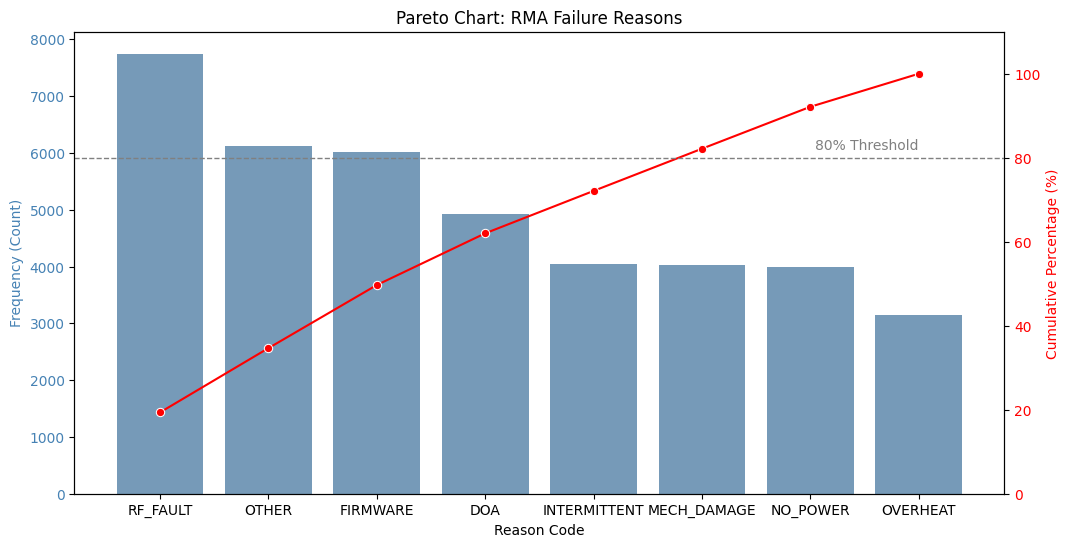

In [34]:
# 1. Calculate Counts and Cumulative Percentage
pareto_df = rma_df['reason_code'].value_counts().reset_index()
pareto_df.columns = ['reason_code', 'count']
pareto_df['cumulative_percentage'] = pareto_df['count'].cumsum() / pareto_df['count'].sum() * 100

# 2. Plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar Plot (Counts)
sns.barplot(data=pareto_df, x='reason_code', y='count', color='steelblue', ax=ax1, alpha=0.8)
ax1.set_ylabel('Frequency (Count)', color='steelblue')
ax1.tick_params(axis='y', labelcolor='steelblue')
ax1.set_xlabel('Reason Code')

# Line Plot (Cumulative %)
ax2 = ax1.twinx()
sns.lineplot(data=pareto_df, x='reason_code', y='cumulative_percentage', color='red', marker='o', ax=ax2)
ax2.set_ylabel('Cumulative Percentage (%)', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylim(0, 110)

# Add 80% cutoff line
ax2.axhline(80, color='grey', linestyle='--', linewidth=1)
ax2.text(len(pareto_df)-1, 82, '80% Threshold', color='grey', ha='right')

plt.title('Pareto Chart: RMA Failure Reasons')
plt.show()

C:\Users\miskibin\AppData\Local\Temp\ipykernel_22264\2735554266.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=region_stats, x='region', y='return_rate_pct', palette='viridis')


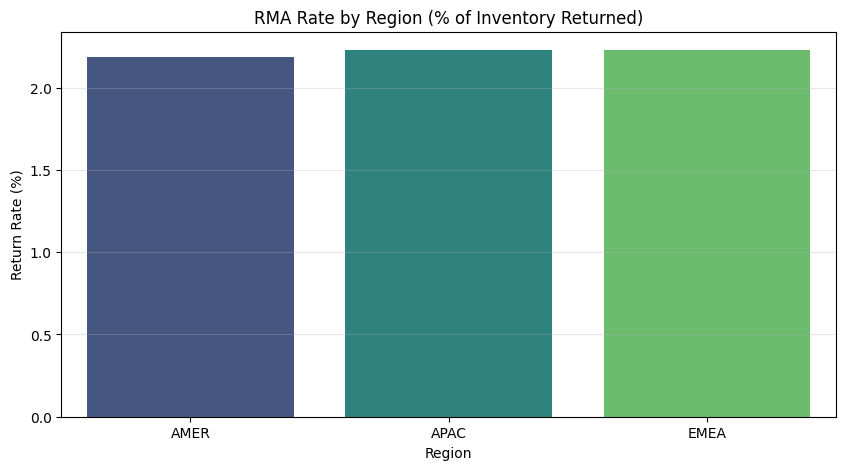

In [35]:
# 1. Get Inventory by Region (joining Inventory -> Sites)
inv_w_region = inventory_df.merge(sites_df[['site_id', 'region']], on='site_id', how='left')
region_inv = inv_w_region.groupby('region')['on_hand_qty'].sum().reset_index(name='total_inventory')

# 2. Get Returns by Region (using rich_rma_df created earlier)
region_rma = rich_rma_df.groupby('region').size().reset_index(name='total_returns')

# 3. Merge and Calculate Rate
region_stats = pd.merge(region_inv, region_rma, on='region')
region_stats['return_rate_pct'] = (region_stats['total_returns'] / region_stats['total_inventory']) * 100

# 4. Visualize
plt.figure(figsize=(10, 5))
sns.barplot(data=region_stats, x='region', y='return_rate_pct', palette='viridis')
plt.title('RMA Rate by Region (% of Inventory Returned)')
plt.ylabel('Return Rate (%)')
plt.xlabel('Region')
plt.grid(axis='y', alpha=0.3)
plt.show()

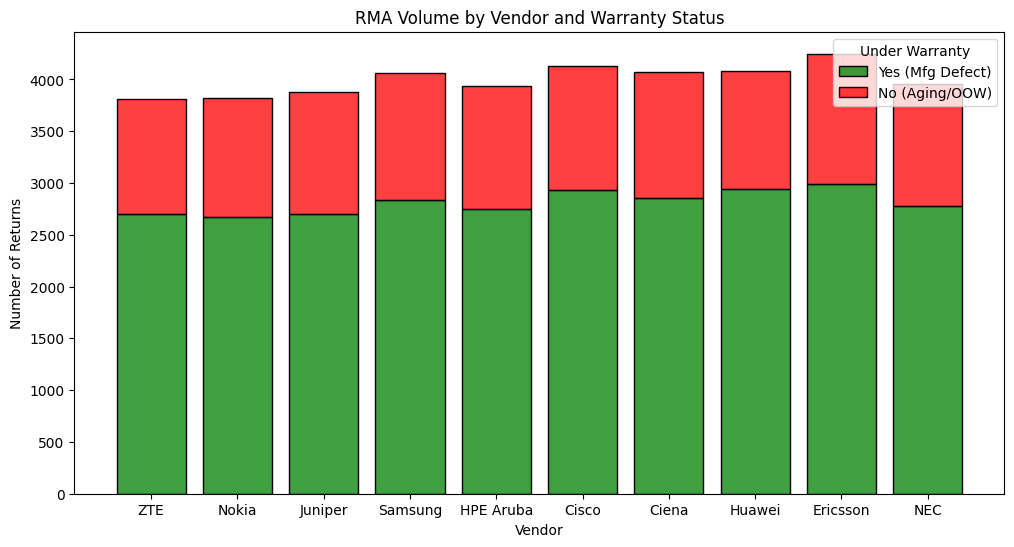

In [36]:
# 1. Aggregate data
vendor_warranty = rich_rma_df.groupby(['vendor', 'under_warranty']).size().reset_index(name='count')

# 2. Plot Stacked Bar Chart
plt.figure(figsize=(12, 6))
sns.histplot(
    data=rich_rma_df, 
    x='vendor', 
    hue='under_warranty', 
    multiple='stack', 
    shrink=0.8, 
    palette={True: 'green', False: 'red'}
)
plt.title('RMA Volume by Vendor and Warranty Status')
plt.xlabel('Vendor')
plt.ylabel('Number of Returns')
plt.legend(title='Under Warranty', labels=['Yes (Mfg Defect)', 'No (Aging/OOW)'])
plt.show()

In [37]:
# 1. Get failure counts by Technology
tech_failures = rich_rma_df['technology'].value_counts().reset_index()
# add what percentage of total items in given technology are failing
sku_health_tech = sku_health.groupby('technology').agg({'total_returns': 'sum', 'total_shipped_qty': 'sum'}).reset_index()
sku_health_tech['failure_rate_pct'] = (sku_health_tech['total_returns'] / sku_health_tech['total_shipped_qty']) * 100


sku_health_tech


,technology,total_returns,total_shipped_qty,failure_rate_pct
0,4G,13972,469335,2.976978
1,5G,18175,612420,2.967735
2,Dual (4G/5G),7853,267339,2.937469


In [38]:
# create rma_enriched (merge with skus and sites    )
# 
rma_enriched = (
    rma_df
    .merge(skus_df, on='sku_id', how='left')
    .merge(sites_df, on='site_id', how='left')
)
rma_enriched

,rma_id,sku_id,site_id,reason_code,rma_date,under_warranty,vendor,category,technology,unit_weight_kg,unit_volume_m3,std_cost_usd,supplier_nominal_lead_time_days,region,country,site_type,operator,latitude,longitude
0,RMA-0000001,SKU-00206,ST-01094,DOA,2024-10-15,True,ZTE,Power,Dual (4G/5G),12.01,0.1249,923.45,58,APAC,Indonesia,Integration Center,NaN,18.57219,92.19677
1,RMA-0000002,SKU-02303,ST-01174,RF_FAULT,2023-11-05,False,Nokia,RAN,4G,28.21,0.2884,785.96,83,EMEA,Sweden,Cell Site,A1 Telekom,44.68328,16.71099
2,RMA-0000003,SKU-04015,ST-01643,RF_FAULT,2025-03-26,True,Juniper,Antenna,Dual (4G/5G),10.51,0.1129,1762.87,26,EMEA,Sweden,Warehouse,NaN,37.37533,4.08934
3,RMA-0000004,SKU-00438,ST-01539,DOA,2025-02-25,True,Samsung,Edge Router,4G,19.21,0.2071,953.13,71,EMEA,Italy,Cell Site,Three,55.56093,18.76542
4,RMA-0000005,SKU-02819,ST-00776,MECH_DAMAGE,2023-06-02,True,HPE Aruba,RAN,4G,7.03,0.0731,713.08,24,EMEA,Germany,Warehouse,NaN,41.91526,12.05442
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,RMA-0039996,SKU-03476,ST-00497,FIRMWARE,2025-04-21,False,NEC,RAN,Dual (4G/5G),39.44,0.4028,264.40,53,APAC,Malaysia,Cell Site,Reliance Jio,35.74836,98.48337
39996,RMA-0039997,SKU-03575,ST-00730,RF_FAULT,2025-06-05,False,HPE Aruba,Cabling,5G,8.58,0.0865,980.73,65,EMEA,Sweden,Cell Site,Vodafone,54.34287,27.81219
39997,RMA-0039998,SKU-03710,ST-01314,DOA,2025-09-01,True,Ciena,RAN,5G,20.76,0.2239,471.04,35,EMEA,Italy,Warehouse,NaN,59.59711,22.92573
39998,RMA-0039999,SKU-01080,ST-00275,INTERMITTENT,2025-04-06,True,Juniper,Optical Transport,5G,12.89,0.1405,823.13,70,EMEA,Germany,Cell Site,Deutsche Telekom,51.32212,28.81153


In [39]:
# STEP 8: Export Enhanced Data for Dashboard

# Create final anomalies export with all key fields
anomalies_export = anomalies[[
    'site_id', 'rma_date', 'rma_count', 'rolling_mean', 'rolling_std', 
    'z_score', 'deviation', 'pct_change', 'severity', 'consecutive_count',
    'region', 'site_type', 'country', 'operator', 'week_number', 'year'
]].copy()

# Sort by severity and z-score for dashboard priority
severity_order = {'Critical': 3, 'High': 2, 'Medium': 1}
anomalies_export['severity_rank'] = anomalies_export['severity'].map(severity_order)
anomalies_export = anomalies_export.sort_values(['severity_rank', 'z_score'], ascending=[False, False])
anomalies_export = anomalies_export.drop('severity_rank', axis=1)

# Save enriched datasets
print("💾 Saving enhanced datasets...")
sku_health.to_csv(DATA_PATH / 'rma' / "sku_health.csv", index=False)
rma_enriched.to_csv(DATA_PATH / 'rma' / "rma_enriched.csv", index=False)
sites_enriched.to_csv(DATA_PATH / 'rma' / "sites_enriched.csv", index=False)
anomalies_export.to_csv(DATA_PATH / 'rma' / "anomalies.csv", index=False)

# Also save full weekly time series for detailed drill-down
weekly_ts_export = weekly_ts.merge(
    sites_df[['site_id', 'region', 'site_type', 'country']], 
    on='site_id', 
    how='left'
)
weekly_ts_export.to_csv(DATA_PATH / 'rma' / "weekly_timeseries.csv", index=False)
anomalies_export.head(10)

💾 Saving enhanced datasets...


,site_id,rma_date,rma_count,rolling_mean,rolling_std,z_score,deviation,pct_change,severity,consecutive_count,region,site_type,country,operator,week_number,year
239,ST-00240,2024-06-03,4,1.00,0.5,6.0,3.00,297.0,Critical,0,EMEA,Warehouse,Germany,NaN,23,2024
914,ST-00935,2024-01-22,4,1.00,0.5,6.0,3.00,297.0,Critical,0,EMEA,Warehouse,France,NaN,4,2024
1382,ST-01429,2024-09-23,4,1.00,0.5,6.0,3.00,297.0,Critical,0,EMEA,Warehouse,Czechia,NaN,39,2024
1539,ST-01564,2023-07-17,4,1.00,0.5,6.0,3.00,297.0,Critical,0,EMEA,Warehouse,Netherlands,NaN,29,2023
1352,ST-01400,2025-06-16,4,1.25,0.5,5.5,2.75,218.3,Critical,0,AMER,Cell Site,Argentina,Verizon,25,2025
1702,ST-01729,2025-05-05,4,1.25,0.5,5.5,2.75,218.3,Critical,0,EMEA,Cell Site,Germany,Vodafone,19,2025
32,ST-00030,2025-07-21,3,1.00,0.5,4.0,2.00,198.0,Critical,0,AMER,Data Center,USA,TIM Brasil,30,2025
47,ST-00045,2023-10-23,3,1.00,0.5,4.0,2.00,198.0,Critical,0,APAC,Cell Site,Vietnam,NTT Docomo,43,2023
55,ST-00056,2023-12-18,3,1.00,0.5,4.0,2.00,198.0,Critical,0,AMER,Cell Site,USA,Verizon,51,2023
56,ST-00058,2024-06-03,3,1.00,0.5,4.0,2.00,198.0,Critical,0,EMEA,Cell Site,UK,Telefónica,23,2024


In [41]:
# Export ALL weekly data (including normal weeks) for comprehensive timeline visualization
# This includes both anomalous and normal weeks for complete trend analysis

# Merge weekly_ts with site metadata
weekly_ts_all = weekly_ts.merge(
    sites_df[['site_id', 'region', 'site_type', 'country', 'operator']], 
    on='site_id', 
    how='left'
)

# Add severity labels to all weeks (including 'Normal')
weekly_ts_all['severity'] = weekly_ts_all.apply(
    lambda row: (
        'Normal' if row['rma_count'] < 2
        else 'Critical' if row['z_score'] >= 3.0
        else 'High' if row['z_score'] >= 2.0
        else 'Medium' if row['z_score'] >= 1.5
        else 'Normal'
    ), 
    axis=1
)

# Add week metadata
weekly_ts_all['week_number'] = weekly_ts_all['rma_date'].dt.isocalendar().week
weekly_ts_all['year'] = weekly_ts_all['rma_date'].dt.year

# Round numeric columns
weekly_ts_all['rolling_mean'] = weekly_ts_all['rolling_mean'].round(2)
weekly_ts_all['rolling_std'] = weekly_ts_all['rolling_std'].round(2)
weekly_ts_all['z_score'] = weekly_ts_all['z_score'].round(2)
weekly_ts_all['deviation'] = weekly_ts_all['deviation'].round(2)
weekly_ts_all['pct_change'] = weekly_ts_all['pct_change'].round(1)

# Add consecutive count info (for sites with recurring issues)
consecutive_sites = (
    anomalies[anomalies['is_consecutive']]
    .groupby('site_id')
    .size()
    .reset_index(name='consecutive_count')
)
weekly_ts_all = weekly_ts_all.merge(consecutive_sites, on='site_id', how='left')
weekly_ts_all['consecutive_count'] = weekly_ts_all['consecutive_count'].fillna(0).astype(int)

# Save comprehensive weekly data
print(f"💾 Exporting {len(weekly_ts_all)} total weekly records (all severity levels)...")
weekly_ts_all.to_csv(DATA_PATH / 'rma' / "weekly_timeseries_complete.csv", index=False)

print(f"\nBreakdown by severity:")
print(weekly_ts_all['severity'].value_counts())
print(f"\nTotal sites: {weekly_ts_all['site_id'].nunique()}")
print(f"Date range: {weekly_ts_all['rma_date'].min().date()} to {weekly_ts_all['rma_date'].max().date()}")

weekly_ts_all.head(20)

💾 Exporting 37370 total weekly records (all severity levels)...

Breakdown by severity:
severity
Normal      35432
High         1826
Critical      109
Medium          3
Name: count, dtype: int64

Total sites: 2000
Date range: 2023-01-02 to 2025-11-03

Breakdown by severity:
severity
Normal      35432
High         1826
Critical      109
Medium          3
Name: count, dtype: int64

Total sites: 2000
Date range: 2023-01-02 to 2025-11-03


,site_id,rma_date,rma_count,rolling_mean,rolling_std,deviation,pct_change,z_score,severity,region,site_type,country,operator,week_number,year,consecutive_count
0,ST-00001,2023-01-09,1,0.00,0.5,1.00,10000.0,2.0,Normal,EMEA,Cell Site,Italy,Three,2,2023,0
1,ST-00001,2023-02-20,1,0.00,0.5,1.00,10000.0,2.0,Normal,EMEA,Cell Site,Italy,Three,8,2023,0
2,ST-00001,2023-04-03,1,1.00,0.5,0.00,0.0,0.0,Normal,EMEA,Cell Site,Italy,Three,14,2023,0
3,ST-00001,2023-04-24,1,1.00,0.5,0.00,0.0,0.0,Normal,EMEA,Cell Site,Italy,Three,17,2023,0
4,ST-00001,2023-05-01,1,1.00,0.5,0.00,0.0,0.0,Normal,EMEA,Cell Site,Italy,Three,18,2023,0
5,ST-00001,2023-07-17,1,1.00,0.5,0.00,0.0,0.0,Normal,EMEA,Cell Site,Italy,Three,29,2023,0
6,ST-00001,2023-09-11,1,1.00,0.5,0.00,0.0,0.0,Normal,EMEA,Cell Site,Italy,Three,37,2023,0
7,ST-00001,2023-12-04,1,1.00,0.5,0.00,0.0,0.0,Normal,EMEA,Cell Site,Italy,Three,49,2023,0
8,ST-00001,2023-12-11,1,1.00,0.5,0.00,0.0,0.0,Normal,EMEA,Cell Site,Italy,Three,50,2023,0
9,ST-00001,2024-01-01,1,1.00,0.5,0.00,0.0,0.0,Normal,EMEA,Cell Site,Italy,Three,1,2024,0
